In [1]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models, utils


In [2]:
def load_and_preprocess_images(folder_path, label):
    images = []
    labels = []

    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img = Image.open(img_path).convert("RGB")  # Load image as RGB
        img_array = np.array(img)
        img_array = img_array / 255.0  # Normalize pixel values to be between 0 and 1

        images.append(img_array)
        labels.append(label)
        
    return images, labels

In [9]:
real_images, real_labels = load_and_preprocess_images("/kaggle/input/facial-data/nvdia5000/nvdia5000", label="real")

fake_images, fake_labels = load_and_preprocess_images("/kaggle/input/facial-data/synthetic5000/synthetic5000", label="fake")


In [10]:
all_images = np.array(real_images + fake_images)
all_labels = real_labels + fake_labels

In [11]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(all_labels)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    all_images, encoded_labels, test_size=0.2, random_state=42
)


In [13]:
# Assuming X_train and X_test are lists of RGB images
X_train_rgb = np.array(X_train).reshape(-1, 128, 128, 3)
X_test_rgb = np.array(X_test).reshape(-1, 128, 128, 3)

In [14]:
from tensorflow.keras import layers, models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=(128, 128, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation="relu"))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])


In [15]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [16]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [17]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/10
250/250 [==============================] - 13s 18ms/step - loss: 0.4335 - accuracy: 0.8108 - val_loss: 0.2634 - val_accuracy: 0.8890
Epoch 2/10
250/250 [==============================] - 3s 12ms/step - loss: 0.1986 - accuracy: 0.9234 - val_loss: 0.2955 - val_accuracy: 0.8595
Epoch 3/10
250/250 [==============================] - 3s 12ms/step - loss: 0.1397 - accuracy: 0.9469 - val_loss: 0.0902 - val_accuracy: 0.9660
Epoch 4/10
250/250 [==============================] - 3s 12ms/step - loss: 0.0765 - accuracy: 0.9724 - val_loss: 0.0938 - val_accuracy: 0.9635
Epoch 5/10
250/250 [==============================] - 3s 12ms/step - loss: 0.0575 - accuracy: 0.9783 - val_loss: 0.0948 - val_accuracy: 0.9675
Epoch 6/10
250/250 [==============================] - 3s 12ms/step - loss: 0.0550 - accuracy: 0.9800 - val_loss: 0.0444 - val_accuracy: 0.9845
Epoch 7/10
250/250 [==============================] - 3s 12ms/step - loss: 0.0201 - accuracy: 0.9934 - val_loss: 0.0616 - val_accuracy: 0.979

In [18]:
train_loss, train_acc = model.evaluate(X_train, y_train)

250/250 [==============================] - 2s 6ms/step - loss: 0.0031 - accuracy: 0.9994


In [19]:
test_loss, test_acc = model.evaluate(X_test, y_test)

63/63 [==============================] - 0s 6ms/step - loss: 0.0246 - accuracy: 0.9915


In [20]:
print(len(X_train))

8000


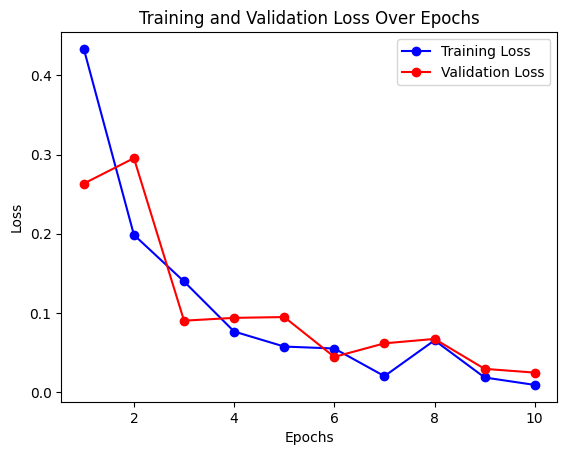

In [21]:
import matplotlib.pyplot as plt


# Extract training and validation loss from the history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting the training and validation loss
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')

# Adding a legend
plt.legend()

# Display the plot
plt.show()


In [22]:
print(f"Train Accuracy: {train_acc}")
print(f"Test Accuracy: {test_acc}")


Train Accuracy: 0.9993749856948853
Test Accuracy: 0.9915000200271606


In [23]:
y_train_pred = model.predict(X_train)
y_train_pred_binary = np.round(y_train_pred).astype(int)


250/250 [==============================] - 1s 4ms/step


In [24]:
y_train_original = label_encoder.inverse_transform(y_train)
y_train_pred_original = label_encoder.inverse_transform(y_train_pred_binary)


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [25]:
y_pred = model.predict(X_test)
y_pred_binary = np.round(y_pred).astype(int)

# Convert numerical labels back to original labels
y_test_original = label_encoder.inverse_transform(y_test)
y_pred_original = label_encoder.inverse_transform(y_pred_binary)


63/63 [==============================] - 0s 4ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [26]:
from sklearn.metrics import classification_report, confusion_matrix

print("Train Classification Report:")
print(classification_report(y_train_original, y_train_pred_original))


print("Train Confusion Matrix:")
print(confusion_matrix(y_train_original, y_train_pred_original))

train_cm = cm = confusion_matrix(y_train_original, y_train_pred_original)


Train Classification Report:
              precision    recall  f1-score   support

        fake       1.00      1.00      1.00      4012
        real       1.00      1.00      1.00      3988

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000

Train Confusion Matrix:
[[4008    4]
 [   1 3987]]


In [27]:

print("Test Classification Report:")
print(classification_report(y_test_original, y_pred_original))

# Generate a confusion matrix
print("TestConfusion Matrix:")
print(confusion_matrix(y_test_original, y_pred_original))

test_cm = confusion_matrix(y_test_original, y_pred_original)


Test Classification Report:
              precision    recall  f1-score   support

        fake       0.99      0.99      0.99       988
        real       0.99      0.99      0.99      1012

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000

TestConfusion Matrix:
[[ 980    8]
 [   9 1003]]


In [28]:
# Save the entire model to a HDF5 file
model.save("FakeFacesDetectionRGB.h5")



/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
